## Concatenating multiple surf sessions together to perform ML analysis on "Simple" Classes:

In [96]:
# Reference: https://github.com/susanli2016/Machine-Learning-with-Python/blob/master/Logistic%20Regression%20balanced.ipynb

### Import necessary libraries:

In [97]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt

plt.rc("font", size=14) 

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#from mpl_toolkits.basemap import Basemap


import os
import datetime
import pytz
import re

import peakutils
import statsmodels.api as sm

import requests

#Read data from a local csv file:

##Will change this to scrape files from the Smartfin.org website later.
#data = pd.read_csv('Motion_13735.CSV', header=0)   
#data = data.dropna()

#Print out the column headings:
#print(data.shape)
#print(list(data.columns))

### Summary of specific ride IDs:

In [98]:
ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']


#ride_ids = ['15629']
# 14743 - Motion Control July 10th
# 14750 - Magnetometer Control July 11th
# 14814 - Pool Displacement Control July 17th
# 14815 - Compass Orientation (Lying on Charger Side) July 19th
# 14816 - Orientation w Higher Sampling (Lying on Charger Side) July 20th
# 14827 - Pool Displacement Control w Higher Sampling (Jul 23)
# 14888 - First Buoy Calibration Experiment (July 30)
# 15218 - Jasmine's Second Ride Sesh filmed with GoPro (Aug 29) //no footage
# 15629 - Jasmine's First Ride Sesh filmed with VIRB (Oct. 24) //first labelled footage!
# 15669 - Jasmine's Second Ride Sesh filmed with VIRB (Nov. 7) //second labelled footage!
# 15692 - Jasmine's 3rd Ride Sesh filmed with VIRB (Nov. 9) //third labelled footage!
# 15686 - Jasmine's 4th Ride Sesh filmed with VIRB (Nov. 11) //fourth labelled footage!
# 15962 - Rachelle's 1st Ride Sesh filmed with VIRB (Nov. 11) //5th labelled footage!
# 15963 - Jasmine's 5th Ride Sesh filmed with VIRB (Nov. 11) //6th labelled footage!
# 15971 - Mexico Sesh filmed with VIRB (Nov. 11) //7th labelled footage!
# 15972 - Jasmine's 7th Ride Sesh filmed with VIRB (Nov. 11) //8th labelled footage!


## Fin ID Scraper (pulls dataframes for specific ride id from website):

In [99]:
#%% Fin ID scraper

def create_ride_from_id():
    # Input fin ID, get all ride IDs
    # base URL to which we'll append given fin IDs
    fin_url_base = 'http://surf.smartfin.org/fin/'

    # Look for the following text in the HTML contents in fcn below
    str_id_ride = 'rideId = \'' # backslash allows us to look for single quote
    str_id_date = 'var date = \'' # backslash allows us to look for single quote

    #%% Ride ID scraper
    # Input ride ID, get ocean and motion CSVs
    # Base URL to which we'll append given ride IDs
    ride_url_base = 'https://surf.smartfin.org/ride/'

    # Look for the following text in the HTML contents in fcn below
    str_id_csv = 'img id="temperatureChart" class="chart" src="' 

    def get_csv_from_ride_id(rid):
        # Build URL for each individual ride
        ride_url = ride_url_base+str(rid)
        print(ride_url)

        # Get contents of ride_url
        html_contents = requests.get(ride_url).text

        # Find CSV identifier 
        loc_csv_id = html_contents.find(str_id_csv)

        # Different based on whether user logged in with FB or Google
        offset_googleOAuth = [46, 114]
        offset_facebkOAuth = [46, 112]
        if html_contents[loc_csv_id+59] == 'f': # Facebook login
            off0 = offset_facebkOAuth[0]
            off1 = offset_facebkOAuth[1]
        else: # Google login
            off0 = offset_googleOAuth[0]
            off1 = offset_googleOAuth[1]

        csv_id_longstr = html_contents[loc_csv_id+off0:loc_csv_id+off1]

    #    print(csv_id_longstr)

        # Stitch together full URL for CSV
        if ("media" in csv_id_longstr) & ("Calibration" not in html_contents): # other junk URLs can exist and break everything

            ocean_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Ocean.CSV'
            motion_csv_url = 'https://surf.smartfin.org/'+csv_id_longstr+'Motion.CSV'

            print(ocean_csv_url)
            # Go to ocean_csv_url and grab contents (theoretically, a CSV)
            ocean_df_small = pd.read_csv(ocean_csv_url, parse_dates = [0])
            elapsed_timedelta = (ocean_df_small['UTC']-ocean_df_small['UTC'][0])
            ocean_df_small['elapsed'] = elapsed_timedelta/np.timedelta64(1, 's')

            motion_df_small = pd.read_csv(motion_csv_url, parse_dates = [0])

            # Reindex on timestamp if there are at least a few rows
            if len(ocean_df_small) > 1:
                ocean_df_small.set_index('UTC', drop = True, append = False, inplace = True)
                motion_df_small.set_index('UTC', drop = True, append = False, inplace = True)

                #print(ocean_df_small)
                #print(motion_df_small)

                #May need to change this sampling interval:
                sample_interval = '33ms'


                ocean_df_small_resample = ocean_df_small.resample(sample_interval).mean()
                motion_df_small_resample = motion_df_small.resample(sample_interval).mean()

                # No need to save many extra rows with no fix
                motion_df_small = motion_df_small[~np.isnan(motion_df_small.Latitude)]

                return ocean_df_small_resample, motion_df_small_resample

        else:
            ocean_df_small_resample = pd.DataFrame() # empty DF just so something is returned
            motion_df_small_resample = pd.DataFrame() 
            return ocean_df_small_resample, motion_df_small_resample

    appended_ocean_list = [] # list of DataFrames from original CSVs
    appended_motion_list = []
    appended_multiIndex = [] # fin_id & ride_id used to identify each DataFrame

    ## Nested loops (for each fin ID, find all ride IDs, then build a DataFrame from all ride CSVs)
    ## (Here, ride IDS are either ocean or motion dataframes)
    count_good_fins = 0

    # Loop over ride_ids and find CSVs
    for rid in ride_ids:
        try:
            new_ocean_df, new_motion_df = get_csv_from_ride_id(rid) # get given ride's CSV from its ride ID using function above
            #print(len(new_ocean_df))
            #print(len(new_motion_df))
            if not new_ocean_df.empty: # Calibration rides, for example
                # Append only if DF isn't empty. There may be a better way to control empty DFs which are created above
                appended_multiIndex.append(str(rid)) # build list to be multiIndex of future DataFrame
                appended_ocean_list.append(new_ocean_df)
                appended_motion_list.append(new_motion_df)
                print("Ride data has been uploaded.")
                #print("Ride: ", rid, "data has been uploaded.")
                count_good_fins += 1

        except: 
            print("Ride threw an exception!")
            #print("Ride ", rid, "threw an exception!")    

    #%% Build the "Master" DataFrame

    # appended_ocean_df.summary()
    df_keys = tuple(appended_multiIndex) # keys gotta be a tuple, a list which data in it cannot be changed
    ocean_df = pd.concat(appended_ocean_list, keys = df_keys, names=['ride_id'])
    motion_df = pd.concat(appended_motion_list, keys = df_keys, names = ['ride_id'])



    #print(motion_df)
    
    
    ##Drop the NA values from the dataframe: 
    motion_df_dropped = motion_df.drop(columns=['Latitude', 'Longitude'])
    motion_df_dropped = motion_df_dropped.dropna(axis=0, how='any')
    #print(motion_df_dropped)
    
    #Create an elapsed_timedelta field:
    motion_df_dropped['TimeDelta'] = (motion_df_dropped['Time']-motion_df_dropped['Time'][0])
    motion_df_dropped.head(10)
    
    return motion_df_dropped
    

## Create dictionary to store {ride_id, dataframe}:

In [100]:
#ride_ids_array = ['15629', '15669', '15692', '15686', '15962', '15963', '15971', '15972']

dataframe_collection = {} 

for ride in ride_ids_array:
    ride_ids = [ride]
    dataframe_collection.update({ride:create_ride_from_id()})
    

https://surf.smartfin.org/ride/15629
https://surf.smartfin.org/media/201810/google_105349665704999793400_0006667E229D_181031013846_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15669
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181107203025_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15692
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181109191556_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15686
https://surf.smartfin.org/media/201811/google_105349665704999793400_0006667E229D_181111203352_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15962
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190208171724_Ocean.CSV
Ride data has been uploaded.
https://surf.smartfin.org/ride/15963
https://surf.smartfin.org/media/201902/google_105349665704999793400_0006667E229D_190222184248_Ocean.CSV
Ride data

## Print to check dataframe collection:

In [101]:
print(dataframe_collection['15629'].head(10))

                                       Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                   
15629   2018-10-31 19:33:01.839  11992061.0    -6.0   540.0    47.0   -24.0   
        2018-10-31 19:33:02.103  11992311.0     4.0   514.0    93.0    10.0   
        2018-10-31 19:33:02.334  11992561.0    14.0   532.0   126.0    40.0   
        2018-10-31 19:33:02.598  11992813.0    13.0   528.0   133.0   -72.0   
        2018-10-31 19:33:02.829  11993063.0    23.0   481.0   121.0   -30.0   
        2018-10-31 19:33:03.093  11993313.0    24.0   452.0   105.0    74.0   
        2018-10-31 19:33:03.357  11993564.0    10.0   467.0    39.0    33.0   
        2018-10-31 19:33:03.588  11993815.0    -5.0   490.0    60.0  -151.0   
        2018-10-31 19:33:03.852  11994065.0    16.0   475.0    94.0  -117.0   
        2018-10-31 19:33:04.116  11994316.0   -17.0   461.0    38.0   -34.0   

                                 IMU G2  IMU G3  IM

In [102]:
print(dataframe_collection['15972'].head(10))

                                        Time  IMU A1  IMU A2  IMU A3  IMU G1  \
ride_id UTC                                                                    
15972   2019-02-25 01:31:59.613  400259893.0   101.0   562.0    71.0   241.0   
        2019-02-25 01:31:59.877  400260143.0   -44.0   311.0   104.0    89.0   
        2019-02-25 01:32:00.108  400260394.0   -32.0   606.0    80.0  -132.0   
        2019-02-25 01:32:00.372  400260644.0     8.0   537.0   102.0  -112.0   
        2019-02-25 01:32:00.636  400260896.0   -70.0   406.0    99.0   -17.0   
        2019-02-25 01:32:00.867  400261145.0   -69.0   469.0    75.0   175.0   
        2019-02-25 01:32:01.131  400261395.0   -67.0   475.0    82.0   111.0   
        2019-02-25 01:32:01.362  400261646.0   -63.0   495.0    70.0   -13.0   
        2019-02-25 01:32:01.626  400261896.0   -60.0   499.0    84.0   -12.0   
        2019-02-25 01:32:01.890  400262147.0   -59.0   484.0    78.0   -46.0   

                                 IMU G2

In [103]:
list(dataframe_collection['15972'])

['Time',
 'IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'TimeDelta']

## Convert the IMU data into real value units:  

In [104]:
def convert_real(input_df):

    df_converted = input_df.copy()

    #Faster way to iterate over columns: 
    df_converted['IMU A1'] = input_df['IMU A1'].apply(lambda x: x*-0.019141) #forwards/backwards
    #Need to find a better way to subtract gravity: 
    df_converted['IMU A2'] = input_df['IMU A2'].apply(lambda x: x*0.019141-9.81)  #upside down/right side up
    df_converted['IMU A3'] = input_df['IMU A3'].apply(lambda x: x*0.019141)  #sideways: negative = left, positive = right

    df_converted['IMU G1'] = input_df['IMU G1'].apply(lambda x: x/8.2)     #roll
    df_converted['IMU G2'] = input_df['IMU G2'].apply(lambda x: x/8.2)     #yaw
    df_converted['IMU G3'] = input_df['IMU G3'].apply(lambda x: x/8.2)     #pitch (flipping forwards/backwards)

    return df_converted

In [105]:
real_dataframe_collection = {}

for ride in ride_ids_array:
    real_df = convert_real(dataframe_collection[ride])
    real_dataframe_collection.update({ride:real_df})
    
real_df.head(10)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta  
ride_id UTC                                                 
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0  
        2019-02-25 01:31:59.877  -149.0   201.0      250.0  
        2019-02-25 01:32:00.108  -152.0   194.0      501.0  
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0

## Add input features (gyro, velocity windowing and BW filtering):

### Adding velocity windowing code (average windowing of recent instantaneous velocities): 

In [106]:
#Velocity windowing code: 

def velocity_window(input_dataframe):

    t = [float(input_dataframe['Time'][i]) for i in range(len(input_dataframe['Time']))]
    a1,a2,a3 = np.array(input_dataframe['IMU A1']),np.array(input_dataframe['IMU A2']),np.array(input_dataframe['IMU A3'])
    
    #a2 = a2-9.81; #need to actually calculate acceleration in correct vector
    a2 = a2-10
    
    v1 = np.zeros((len(input_dataframe),1))
    v2 = np.zeros((len(input_dataframe),1))
    v3 = np.zeros((len(input_dataframe),1))
    
    delta_t = 0.250; # TODO: calculate real deltas using the UTC time

    # Use magnitude as feature?
    # stats stuff in windows (means, medians, max/min)
    # fft?
    # velocity towards shore

    #Need to reset velocity to 0 when in small range to avoid drift
    mag = 0
    for i in range(len(input_dataframe)):
        # delta_t = ?   
        if i < 1:
            v1[i] = a1[i]*delta_t/2
            v2[i] = a2[i]*delta_t/2
            v3[i] = a3[i]*delta_t/2
            
        elif (-mag < v1[i] < mag) or (-mag < v2[i] < mag) or (-mag < v3[i] < mag):
            if (-mag < v1[i] < mag):
                v1[i] = 0
            if (-mag < v2[i] < mag):
                v2[i] = 0
            if (-mag < v3[i] < mag):
                v3[i] = 0
        else:
            v1[i] = v1[i] + (a1[i-2] + a1[i-1] + a1[i])*delta_t/3
            v2[i] = v2[i] + (a2[i-2] + a2[i-1] + a2[i])*delta_t/3  
            v3[i] = v3[i] + (a3[i-2] + a3[i-1] + a3[i])*delta_t/3
    
    
    #Creating dataframe columns from arrays:
    #v1_df = pd.DataFrame(v1,columns=['IMU V1'])
    #v2_df = pd.DataFrame(v2,columns=['IMU V2'])
    #v3_df = pd.DataFrame(v3,columns=['IMU V3'])


    #Input velocity into dataframes: 
    new_input_dataframe = input_dataframe
    new_input_dataframe['IMU V1'] = v1
    new_input_dataframe['IMU V2'] = v2
    new_input_dataframe['IMU V3'] = v3
    
    return new_input_dataframe


In [107]:
#Update a new dataframe collection with velocity added as an input feature:
v_dataframe_collection = {}

for ride in ride_ids_array:
    velocity_added_df = velocity_window(real_dataframe_collection[ride])
    v_dataframe_collection.update({ride:velocity_added_df})
    
velocity_added_df.head(100)

Time    IMU A1     IMU A2    IMU A3  \
ride_id UTC                                                                   
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241   0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204  -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512   1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128   0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870  -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729  -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447  -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883  -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460  -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319  -0.545756  1.492998   
        2019-02-25 01:32:02.121  400262397.0  1.167601   0.105038  1.339870   
        2019-02-25 01:32:02.385  400262649.0  1.091037  -0.316064  1.760972   
        2019-02-25 01:32:02.649  400262899.0  1.014473  -0.852012  1.894959   
        2019-02-25 01:32:02.880  400263149.0  1.071896  -0.450051  1.760972   
        2019-02-25 01:32:03.144  400263400.0  1.091037  -0.622320  1.703549   
        2019-02-25 01:32:03.408  400263651.0  1.052755  -0.564897  1.473857   
        2019-02-25 01:32:03.639  400263901.0  1.033614   0.698409  1.588703   
        2019-02-25 01:32:03.903  400264152.0  0.995332  -1.024281  1.894959   
        2019-02-25 01:32:04.167  400264402.0  0.957050  -1.139127  1.607844   
        2019-02-25 01:32:04.398  400264646.0  1.033614   0.277307  1.512139   
        2019-02-25 01:32:04.662  400264896.0  1.033614   0.143320  1.607844   
        2019-02-25 01:32:04.893  400265147.0  1.014473  -0.698884  1.416434   
        2019-02-25 01:32:05.157  400265397.0  1.033614  -0.220359  1.626985   
        2019-02-25 01:32:05.421  400265650.0  0.995332  -0.201218  1.626985   
        2019-02-25 01:32:05.652  400265900.0  0.976191  -0.756307  1.397293   
        2019-02-25 01:32:05.916  400266151.0  0.976191  -1.043422  1.894959   
        2019-02-25 01:32:06.180  400266402.0  1.071896   0.047615  1.588703   
        2019-02-25 01:32:06.411  400266651.0  0.861345  -0.392628  1.339870   
        2019-02-25 01:32:06.675  400266893.0  0.918768  -0.220359  1.569562   
        2019-02-25 01:32:06.906  400267143.0  0.995332  -0.048090  1.531280   
        2019-02-25 01:32:07.170  400267393.0  0.976191  -0.832871  1.416434   
        2019-02-25 01:32:07.401  400267644.0  0.937909  -0.737166  2.239497   
        2019-02-25 01:32:07.665  400267895.0  0.746499   1.272639 -0.076564   
        2019-02-25 01:32:07.929  400268145.0  0.803922  -0.201218  1.167601   
        2019-02-25 01:32:08.160  400268395.0  1.167601  -0.564897  2.698881   
        2019-02-25 01:32:08.424  400268645.0  0.784781  -0.928576  1.722690   
        2019-02-25 01:32:08.688  400268895.0  0.325397   0.698409  1.646126   
        2019-02-25 01:32:08.919  400269146.0  1.531280  -0.718025  2.086369   
        2019-02-25 01:32:09.183  400269396.0  1.378152  -0.316064  1.378152   
        2019-02-25 01:32:09.447  400269647.0  1.244165   0.028474  1.722690   
        2019-02-25 01:32:09.678  400269897.0  3.139124   1.119511  2.239497   
        2019-02-25 01:32:09.942  400270147.0 -0.363679   1.904292  0.937909   
        2019-02-25 01:32:10.173  400270397.0  1.359011  -1.273114 -1.397293   
        2019-02-25 01:32:10.437  400270648.0  1.378152  -2.249305  2.411766   
        2019-02-25 01:32:10.701  400270898.0  1.282447  -1.789921  2.143792   
        2019-02-25 01:32:10.932  400271149.0  1.397293   0.200743  1.225024   
        2019-02-25 01:32:11.196  400271399.0 -0.210551   0.277307  1.148460   
        2019-02-25 01:32:11.460  400271649.0  0.421102   0.430435  1.282447   
        2019-02-25 01:32:11.691  400271899.0 -0.019141  -1.732498  1.780113   
        201

In [108]:
#Test by printing out some values: 
v_dataframe_collection['15972'].head(20)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   
        2019-02-25 01:32:02.121  400262397.0  1.167601  0.105038  1.339870   
        2019-02-25 01:32:02.385  400262649.0  1.091037 -0.316064  1.760972   
        2019-02-25 01:32:02.649  400262899.0  1.014473 -0.852012  1.894959   
        2019-02-25 01:32:02.880  400263149.0  1.071896 -0.450051  1.760972   
        2019-02-25 01:32:03.144  400263400.0  1.091037 -0.622320  1.703549   
        2019-02-25 01:32:03.408  400263651.0  1.052755 -0.564897  1.473857   
        2019-02-25 01:32:03.639  400263901.0  1.033614  0.698409  1.588703   
        2019-02-25 01:32:03.903  400264152.0  0.995332 -1.024281  1.894959   
        2019-02-25 01:32:04.167  400264402.0  0.957050 -1.139127  1.607844   
        2019-02-25 01:32:04.398  400264646.0  1.033614  0.277307  1.512139   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   
        2019-02-25 01:32:02.121  -2.073171   0.609756   1.951220   -84.0   
        2019-02-25 01:32:02.385  -3.292683  -0.243902  -1.463415   -83.0   
        2019-02-25 01:32:02.649   2.439024   2.439024  -0.975610   -76.0   
        2019-02-25 01:32:02.880   5.365854   4.024390   5.853659   -87.0   
        2019-02-25 01:32:03.144  -2.926829   3.292683   2.804878   -88.0   
        2019-02-25 01:32:03.408   0.853659   2.682927   0.243902   -88.0   
        2019-02-25 01:32:03.639 -10.609756   0.975610  -5.975610   -85.0   
        2019-02-25 01:32:03.903   6.341463   1.951220   1.219512   -84.0   
        2019-02-25 01:32:04.167  20.731707   5.609756   7.195122   -84.0   
        2019-02-25 01:32:04.398  -1.585366   4.146341   1.585366   -86.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
  

### Adding ROC (rate of change) of gyroscope windowing code: 

In [109]:
def roc_gyro(df):
    
    #Pulling gyroscope data from dataframe:
    gyro = df[['IMU G1','IMU G2','IMU G3']]
    g1_tmp,g2_tmp,g3_tmp = np.array(gyro['IMU G1']),np.array(gyro['IMU G2']),np.array(gyro['IMU G3'])

    roc_g1, roc_g2, roc_g3 = [], [], []

    #Calculating rate of change of gyroscope between current and previous data point:

    for idx in range(0,len(g1_tmp)):
        if idx == 0: 
            roc1, roc2, roc3 = 0,0,0
        else:
            tmp1,tmp2,tmp3 = g1_tmp[idx-1],g2_tmp[idx-1],g3_tmp[idx-1]
            roc1 = g1_tmp[idx]-tmp1
            roc2 = g2_tmp[idx]-tmp2
            roc3 = g3_tmp[idx]-tmp3
            
        roc_g1.append(roc1)
        roc_g2.append(roc2)
        roc_g3.append(roc3)
        
            
    df['ROC_G1'] = roc_g1
    df['ROC_G2'] = roc_g1
    df['ROC_G3'] = roc_g1
    
    return df

In [110]:
#Update a new dataframe collection with velocity added as an input feature:
g_dataframe_collection = {}

for ride in ride_ids_array:
    gyro_added_df = roc_gyro(v_dataframe_collection[ride])
    g_dataframe_collection.update({ride:gyro_added_df})
    
gyro_added_df.head(10)

Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  0.317422   
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  0.303066   
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0  0.290305   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15972   2019-02-25 01:31:59.613 -1.131595  0.169876   0.000000   0.000000   
        2019-02-25 01:31:59.877 -3.639746  0.465764 -18.536585 -18.536585   
        2019-02-25 01:32:00.108 -2.593372  0.406746 -26.951220 -26.951220   
        2019-02-25 01:32:00.372 -2.633249  0.456194   2.439024   2.439024   
        2019-02-25 01:32:00.636 -2.481716  0.448218  11.585366  11.585366   
        2019-02-25 01:32:00.867 -2.700242  0.440243  23.414634  23.414634   
        2019-02-25 01:32:01.131 -2.799138  0.408341  -7.804878  -7.804878   
        2019-02-25 01:32:01.362 -2.657175  0.362084 -15.121951 -15.121951   
        2019-02-25 01:32:01.626 -2.609323  0.376440   0.121951   0.121951   
        2019-02-25 01:32:01.890 -2.594967  0.370059  -4.146341  -4.146341   

                                    ROC_G3  
ride_id UTC                                 
15972   2019-02-25 01:31:59.613   0.000000  
        2019-02-25 01:31:59.877 -18.536585  
        2019-02-25 01:32:00.108 -26.951220  
        2019-02-25 01:32:00.372   2.439024  
        2019-02-25 01:32:00.636  11.585366  
        2019-02-25 01:32:00.867  23.414634  
        2019-02-25 01:32:01.131  -7.8048

## Sync Smartfin Data with Footage Labels

In [111]:
import time

def label_complex_data(footage_file, pd_dataframe, sync_threshold = 20000):
    #First, perform sync
    sync_buf = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 2) 
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip()
            if labelled_time[1].lower() == 'sync': #Assumption that first word in sync line is "sync"
                sync_time = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000
                index = 0
                start = 0
                end = 0
                #Syncing occurs when IMU A2 data is negative for a longer period than the provided threshold
                #Default is 20 seconds
                for data in pd_dataframe['IMU A2']:
                    if data < 0 and start == 0:
                        start = pd_dataframe['TimeDelta'][index]
                    elif data > 0 and start != 0:
                        end = pd_dataframe['TimeDelta'][index]
                        if end - start > sync_threshold:
                            sync_buf = start - sync_time
                            break
                        start = 0
                    index += 1
                    
                    
    #Create new DataFrame containing label info
    accepted_labels = set()
    
    #Simple:
    #accepted_labels = {'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'DISCARD', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'NEW', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF', 'DONE'}
    
    #Complex:
    accepted_labels = {'SYNC', 'WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'DISCARD', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'NEW', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF', 'DONE'}
    
    
    label_frame = pd.DataFrame(0, index = pd_dataframe.index, columns = accepted_labels)
    for label in accepted_labels:
        label_frame[label] = [0] * len(pd_dataframe['Time'])

    
    #Convention of labelled footage text: "MINUTE:SECOND LABEL"
    elapsed_time = 0
    cur_label = ''
    buffer = 0
    with open(footage_file) as file:
        for line in file:
            labelled_time = line.split(None, 1) #complex requires the entire label
                
            #If the first word is not a properly formatted time, the line cannot be read
            try:
                cur_time = time.strptime(labelled_time[0], '%M:%S')
                cur_timeMS = cur_time.tm_min * 60 * 1000 + cur_time.tm_sec * 1000 + sync_buf
            except:
                continue
            labelled_time[1] = labelled_time[1].rstrip() #Remove potential newline
                
            #Check for end of video and modify buffer accordingly
            if labelled_time[1].lower() == 'new': #Assumption that label end video with "new"
                buffer += cur_timeMS
                
                
            if labelled_time[1].upper() in accepted_labels:
                while (elapsed_time < len(pd_dataframe['Time']) and
                      (np.isnan(pd_dataframe['TimeDelta'][elapsed_time]) or
                       pd_dataframe['TimeDelta'][elapsed_time] < cur_timeMS + buffer)):
                    if cur_label != '':
                        label_frame[cur_label][elapsed_time] = 1
                    elapsed_time += 1
                if labelled_time[1].upper() != 'NEW':
                    cur_label = labelled_time[1].upper()

    labelled = pd.concat([pd_dataframe, label_frame], axis = 1)

    return labelled

pd.options.display.max_rows = 5000
pd.options.display.max_columns = 5000

#motion_df_simple = label_data('Footage3.txt')
#print(motion_df_simple.size)
#motion_df_simple.head(10)

## Sync all rides in dictionary with their labelled footage: 

In [112]:
## Sync all rides with their labelled footage: 
footage_files = ['Footage.txt', 'Footage2.txt', 'Footage3.txt', 'Footage4.txt', 'Footage5.txt', 'Footage6.txt', 'Footage7.txt', 'Footage8.txt']
footage_ride_zip = zip(footage_files, ride_ids_array)

labelled_dataframe_collection = {}

for ftf, ride in footage_ride_zip:
    labelled_df = label_complex_data(ftf, g_dataframe_collection[ride], sync_threshold = 20000)
    labelled_dataframe_collection.update({ride:labelled_df})
    

print(list(labelled_dataframe_collection['15972']))
labelled_dataframe_collection['15972'].head(10)

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'PULL-BACK LEASH', "TURNING TO SURFER'S RIGHT", 'PADDLING FOR A WAVE', 'SURFING', 'PADDLING INTO WAVES', 'WALKING IN WATER', 'STEP-OFF', 'NEW', 'SIT-UP', "TURNING TO SURFER'S LEFT", 'FLIP BOARD RIGHT-SIDE UP', 'DONE', 'FLOATING', 'PUSH-OFF', 'PADDLING FOR POSITION', 'SYNC', 'LAY-DOWN', 'DISCARD', 'SIT-BACK', 'WIPE-OUT', 'POP-UP']


Time    IMU A1    IMU A2    IMU A3  \
ride_id UTC                                                                  
15972   2019-02-25 01:31:59.613  400259893.0 -1.933241  0.947242  1.359011   
        2019-02-25 01:31:59.877  400260143.0  0.842204 -3.857149  1.990664   
        2019-02-25 01:32:00.108  400260394.0  0.612512  1.789446  1.531280   
        2019-02-25 01:32:00.372  400260644.0 -0.153128  0.468717  1.952382   
        2019-02-25 01:32:00.636  400260896.0  1.339870 -2.038754  1.894959   
        2019-02-25 01:32:00.867  400261145.0  1.320729 -0.832871  1.435575   
        2019-02-25 01:32:01.131  400261395.0  1.282447 -0.718025  1.569562   
        2019-02-25 01:32:01.362  400261646.0  1.205883 -0.335205  1.339870   
        2019-02-25 01:32:01.626  400261896.0  1.148460 -0.258641  1.607844   
        2019-02-25 01:32:01.890  400262147.0  1.129319 -0.545756  1.492998   

                                    IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                
15972   2019-02-25 01:31:59.613  29.390244  15.121951  -2.560976  -107.0   
        2019-02-25 01:31:59.877  10.853659   6.463415 -33.536585   -85.0   
        2019-02-25 01:32:00.108 -16.097561   2.560976   3.414634   -68.0   
        2019-02-25 01:32:00.372 -13.658537   3.902439   3.048780   -77.0   
        2019-02-25 01:32:00.636  -2.073171   6.585366   0.365854   -81.0   
        2019-02-25 01:32:00.867  21.341463  10.121951   1.097561   -74.0   
        2019-02-25 01:32:01.131  13.536585   8.170732   2.317073   -86.0   
        2019-02-25 01:32:01.362  -1.585366   5.487805   2.439024   -88.0   
        2019-02-25 01:32:01.626  -1.463415   4.390244   0.121951   -91.0   
        2019-02-25 01:32:01.890  -5.609756   2.926829   1.341463   -85.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:31:59.613  -169.0   181.0        0.0 -0.241655   
        2019-02-25 01:31:59.877  -149.0   201.0      250.0 -0.877296   
        2019-02-25 01:32:00.108  -152.0   194.0      501.0 -0.039877   
        2019-02-25 01:32:00.372  -167.0   175.0      751.0  0.108466   
        2019-02-25 01:32:00.636  -171.0   167.0     1003.0  0.149938   
        2019-02-25 01:32:00.867  -170.0   168.0     1252.0  0.208956   
        2019-02-25 01:32:01.131  -166.0   202.0     1502.0  0.328587   
        2019-02-25 01:32:01.362  -162.0   196.0     1753.0  0.317422   
        2019-02-25 01:32:01.626  -159.0   193.0     2003.0  0.303066   
        2019-02-25 01:32:01.890  -163.0   193.0     2254.0  0.290305   

                                   IMU V2    IMU V3     ROC_G1     ROC_G2  \
ride_id UTC                                                                 
15972   2019-02-25 01:31:59.613 -1.131595  0.169876   0.000000   0.000000   
        2019-02-25 01:31:59.877 -3.639746  0.465764 -18.536585 -18.536585   
        2019-02-25 01:32:00.108 -2.593372  0.406746 -26.951220 -26.951220   
        2019-02-25 01:32:00.372 -2.633249  0.456194   2.439024   2.439024   
        2019-02-25 01:32:00.636 -2.481716  0.448218  11.585366  11.585366   
        2019-02-25 01:32:00.867 -2.700242  0.440243  23.414634  23.414634   
        2019-02-25 01:32:01.131 -2.799138  0.408341  -7.804878  -7.804878   
        2019-02-25 01:32:01.362 -2.657175  0.362084 -15.121951 -15.121951   
        2019-02-25 01:32:01.626 -2.609323  0.376440   0.121951   0.121951   
        2019-02-25 01:32:01.890 -2.594967  0.370059  -4.146341  -4.146341   

                                    ROC_G3  PULL-BACK LEASH  \
ride_id UTC                                                   
15972   2019-02-25 01:31:59.613   0.000000                0   
        2019-02-25 01:31:59.877 -18.536585                0   
        2019-02-25 01:32:00.108 -26.951220                0   
        2019-02-25 01:32:00.372   2.439024                0   
        2019-02-25 01:

In [113]:
print(list(labelled_dataframe_collection['15629']))

['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'PULL-BACK LEASH', "TURNING TO SURFER'S RIGHT", 'PADDLING FOR A WAVE', 'SURFING', 'PADDLING INTO WAVES', 'WALKING IN WATER', 'STEP-OFF', 'NEW', 'SIT-UP', "TURNING TO SURFER'S LEFT", 'FLIP BOARD RIGHT-SIDE UP', 'DONE', 'FLOATING', 'PUSH-OFF', 'PADDLING FOR POSITION', 'SYNC', 'LAY-DOWN', 'DISCARD', 'SIT-BACK', 'WIPE-OUT', 'POP-UP']


## Clean up the dataset, create "simple" labels: 

In [114]:
##Clean the dataset: 

#Jasmine checked correctness of this function on Feb. 25, 2019
#All values contained start after the "sync" process (walking in water begins after sync step dropped)


#Create simple labels from data: 
clean_df_collection = {}
simple_cols = ["SURFING", "PADDLING FOR A WAVE", "PADDLING INTO WAVES", "PADDLING FOR POSITION", "FLOATING"]
labelled_cols = ['WALKING IN WATER', 'PUSH-OFF', 'PADDLING INTO WAVES', 'SIT-UP', 'FLOATING', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'PADDLING FOR A WAVE', 'SIT-BACK', 'POP-UP', 'SURFING', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'PADDLING FOR POSITION', 'STEP-OFF']

drop_cols = ["NEW", "DONE", "SYNC", "DISCARD"]
for label in labelled_cols: 
    if label not in simple_cols: 
        drop_cols.append(label)

print("Dropping columns: ", drop_cols, "\n")


for ride in ride_ids_array:
    
    #Delete any rows where all values in labelled set are 0: 
    df = labelled_dataframe_collection[ride]
    df = df.loc[(df[labelled_cols]!=0).any(axis=1)]
    
    #Delete the "formatting" columns from labelled footage
    for dc in drop_cols: 
        if dc in list(df):
            df.drop(columns=[dc], inplace=True)
    

    clean_df_collection.update({ride:df})
    
    

print("Keeping Columns: ", list(df))
clean_df_collection['15972'].head(10)

Dropping columns:  ['NEW', 'DONE', 'SYNC', 'DISCARD', 'WALKING IN WATER', 'PUSH-OFF', 'SIT-UP', "TURNING TO SURFER'S LEFT", 'LAY-DOWN', 'SIT-BACK', 'POP-UP', 'WIPE-OUT', "TURNING TO SURFER'S RIGHT", 'FLIP BOARD RIGHT-SIDE UP', 'PULL-BACK LEASH', 'STEP-OFF'] 

Keeping Columns:  ['Time', 'IMU A1', 'IMU A2', 'IMU A3', 'IMU G1', 'IMU G2', 'IMU G3', 'IMU M1', 'IMU M2', 'IMU M3', 'TimeDelta', 'IMU V1', 'IMU V2', 'IMU V3', 'ROC_G1', 'ROC_G2', 'ROC_G3', 'PADDLING FOR A WAVE', 'SURFING', 'PADDLING INTO WAVES', 'FLOATING', 'PADDLING FOR POSITION']


Time    IMU A1     IMU A2     IMU A3  \
ride_id UTC                                                                    
15972   2019-02-25 01:32:45.186  400305147.0  1.033614 -12.968265  11.714292   
        2019-02-25 01:32:45.417  400305399.0  1.512139  -7.761913   6.814196   
        2019-02-25 01:32:45.681  400305648.0 -0.229692   2.057420   4.287584   
        2019-02-25 01:32:45.912  400305899.0 -1.435575   2.689073   5.206352   
        2019-02-25 01:32:46.176  400306149.0  0.880486  -2.938381   3.636790   
        2019-02-25 01:32:46.440  400306400.0  0.076564  -3.991136   0.421102   
        2019-02-25 01:32:46.671  400306645.0 -1.167601   1.042947  -0.325397   
        2019-02-25 01:32:46.935  400306896.0  0.708217   1.081229  -1.914100   
        2019-02-25 01:32:47.166  400307146.0  0.306256   1.272639   1.894959   
        2019-02-25 01:32:47.430  400307397.0  0.803922  -3.168073   3.062560   

                                     IMU G1     IMU G2     IMU G3  IMU M1  \
ride_id UTC                                                                 
15972   2019-02-25 01:32:45.186  128.658537   8.414634   0.121951   -66.0   
        2019-02-25 01:32:45.417  171.341463   5.731707  15.365854   -53.0   
        2019-02-25 01:32:45.681   59.268293 -20.975610  15.243902   -75.0   
        2019-02-25 01:32:45.912  -17.439024 -24.634146 -12.804878   -76.0   
        2019-02-25 01:32:46.176   22.560976   9.634146 -33.048780   -47.0   
        2019-02-25 01:32:46.440   42.439024  41.585366  -0.853659   -27.0   
        2019-02-25 01:32:46.671   20.487805  33.658537  19.024390   -47.0   
        2019-02-25 01:32:46.935   -2.926829  13.902439  22.804878   -98.0   
        2019-02-25 01:32:47.166  -65.853659   2.439024   7.560976  -107.0   
        2019-02-25 01:32:47.430   15.853659   1.097561 -18.658537   -89.0   

                                 IMU M2  IMU M3  TimeDelta    IMU V1  \
ride_id UTC                                                            
15972   2019-02-25 01:32:45.186   -46.0  -166.0    45254.0  0.197790   
        2019-02-25 01:32:45.417  -153.0   -49.0    45506.0  0.280735   
        2019-02-25 01:32:45.681  -175.0   123.0    45755.0  0.193005   
        2019-02-25 01:32:45.912  -176.0   146.0    46006.0 -0.012761   
        2019-02-25 01:32:46.176  -177.0   149.0    46256.0 -0.065398   
        2019-02-25 01:32:46.440  -163.0   173.0    46507.0 -0.039877   
        2019-02-25 01:32:46.671  -139.0   215.0    46752.0 -0.017546   
        2019-02-25 01:32:46.935  -136.0   224.0    47003.0 -0.031902   
        2019-02-25 01:32:47.166  -165.0   185.0    47253.0 -0.012761   
        2019-02-25 01:32:47.430  -175.0   151.0    47504.0  0.151533   

                                   IMU V2    IMU V3      ROC_G1      ROC_G2  \
ride_id UTC                                                                   
15972   2019-02-25 01:32:45.186 -6.179119  2.083179   72.682927   72.682927   
        2019-02-25 01:32:45.417 -5.482068  2.400600   42.682927   42.682927   
        2019-02-25 01:32:45.681 -4.056063  1.901339 -112.073171 -112.073171   
        2019-02-25 01:32:45.912 -2.751285  1.359011  -76.707317  -76.707317   
        2019-02-25 01:32:46.176 -2.349324  1.094227   40.000000   40.000000   
        2019-02-25 01:32:46.440 -2.853370  0.772020   19.878049   19.878049   
        2019-02-25 01:32:46.671 -2.990548  0.311041  -21.951220  -21.951220   
        2019-02-25 01:32:46.935 -2.655580 -0.151533  -23.414634  -23.414634   
        2019-02-25 01:32:47.166 -2.216932 -0.028712  -62.926829  -62.926829   
        2019-02-25 01:32:47.430 -2.567850  0.253618   81.707317   81.707317   

                                     ROC_G3  PADDLING FOR A WAVE  SURFING  \
ride_id UTC                                                                 
15972   2019-02-25 01:32:45.186   72.682927                    0        0   
        2019-02-25 01:32:45.417   42.682927                    0        0   
        2019-02-25 01:32:45.681 

## Concatenate rides together:

In [115]:
df1_complex = clean_df_collection[ride_ids_array[0]]
df2_complex = clean_df_collection[ride_ids_array[1]]
df3_complex = clean_df_collection[ride_ids_array[2]]
df4_complex = clean_df_collection[ride_ids_array[3]]
df5_complex = clean_df_collection[ride_ids_array[4]]
df6_complex = clean_df_collection[ride_ids_array[5]]
df7_complex = clean_df_collection[ride_ids_array[6]]
df8_complex = clean_df_collection[ride_ids_array[7]]

new_df_array = [df1_complex, df2_complex, df3_complex, df4_complex, df5_complex, df6_complex, df7_complex, df8_complex]

    
print(df1_complex.shape)

print(df2_complex.shape)

print(df3_complex.shape)

print(df4_complex.shape)

print(df5_complex.shape)

print(df6_complex.shape)

print(df7_complex.shape)


df_concatenated = pd.concat(new_df_array, sort=False)

print("Shape of first dataframe:", df1_complex.shape)
print("Shape of all combined dataframes:", df_concatenated.shape)

print("Printing dataframe...")
print(df_concatenated.shape)

(12806, 22)
Printing dataframe...
(12806, 22)


## Create single column of class labels from dataframe:

In [130]:
#Only keep the necessary input features:

#list(df_concatenated.iloc[:, 0:16])

multiclass_df = df_concatenated.drop(columns=["Time", "TimeDelta"])
multiclass_df = multiclass_df.iloc[:, 0:15]
list(multiclass_df)

['IMU A1',
 'IMU A2',
 'IMU A3',
 'IMU G1',
 'IMU G2',
 'IMU G3',
 'IMU M1',
 'IMU M2',
 'IMU M3',
 'IMU V1',
 'IMU V2',
 'IMU V3',
 'ROC_G1',
 'ROC_G2',
 'ROC_G3']

In [131]:
print("Creating multiclass dataframe...")

parse_df = df_concatenated.iloc[:, 17:]
print(list(parse_df))

#Parse the columns of the original dataframe to extract labels into a single column for the new multiclass df. 
def parse_func(x):
    l=[]
    val = 1
    for col in parse_df:
        if x[col] == val:
            l.append(col)

    return pd.Series(l)

parse_df = parse_df.apply(parse_func, axis=1)
#print(parse_df.head(10))

#Concatenate the parse column with the multiclass dataframe. 
simple_multiclass_df = pd.concat([multiclass_df, parse_df], axis=1, sort=False)

#Rename labelled column: 
col_names = list(simple_multiclass_df)
col_names[-1] = "simple_label"
simple_multiclass_df.columns = col_names

print("\n Done creating simple multiclass df.")

simple_multiclass_df.head(10)


Creating multiclass dataframe...
['PADDLING FOR A WAVE', 'SURFING', 'PADDLING INTO WAVES', 'FLOATING', 'PADDLING FOR POSITION']

 Done creating simple multiclass df.


IMU A1     IMU A2    IMU A3      IMU G1  \
ride_id UTC                                                                  
15692   2018-11-09 19:17:35.958 -0.459384 -19.476205 -0.995332   -4.634146   
        2018-11-09 19:17:36.156 -0.516807 -19.284795 -0.765640    9.146341   
        2018-11-09 19:17:36.354 -0.689076 -19.380500 -0.440243    2.195122   
        2018-11-09 19:17:36.552 -1.225024 -19.820743 -0.574230    1.951220   
        2018-11-09 19:17:36.750 -1.282447 -21.505151  2.009805   20.121951   
        2018-11-09 19:17:36.948  0.708217 -24.089186  0.440243  163.658537   
        2018-11-09 19:17:37.212 -0.306256 -12.815137  2.660599  227.926829   
        2018-11-09 19:17:37.443  1.014473  -7.206824  6.431376  201.341463   
        2018-11-09 19:17:37.707  4.325866  39.248383 -5.225493   87.317073   
        2018-11-09 19:17:37.971  1.492998   2.019138  2.584035   16.829268   

                                    IMU G2     IMU G3  IMU M1  IMU M2  IMU M3  \
ride_id UTC                                                                     
15692   2018-11-09 19:17:35.958  -1.463415   0.731707   -78.0   320.0   -16.0   
        2018-11-09 19:17:36.156   0.365854   1.707317   -83.0   325.0   -19.0   
        2018-11-09 19:17:36.354   4.390244  -1.219512   -81.0   319.0   -33.0   
        2018-11-09 19:17:36.552   6.585366   0.000000   -88.0   314.0   -28.0   
        2018-11-09 19:17:36.750  16.463415   4.756098   -76.0   316.0   -38.0   
        2018-11-09 19:17:36.948  25.243902  19.390244   -66.0   270.0  -102.0   
        2018-11-09 19:17:37.212  20.487805  13.048780   -26.0    54.0  -164.0   
        2018-11-09 19:17:37.443   7.317073  16.463415   -15.0  -131.0   -57.0   
        2018-11-09 19:17:37.707  -2.195122  23.536585   -37.0  -161.0   191.0   
        2018-11-09 19:17:37.971 -10.365854  -3.536585   -34.0  -166.0   190.0   

                                   IMU V1    IMU V2    IMU V3      ROC_G1  \
ride_id UTC                                                                 
15692   2018-11-09 19:17:35.958 -0.114846 -7.383407 -0.253618   -6.585366   
        2018-11-09 19:17:36.156 -0.113251 -7.377027 -0.264784   13.780488   
        2018-11-09 19:17:36.354 -0.138772 -7.345125 -0.183435   -6.951220   
        2018-11-09 19:17:36.552 -0.202576 -7.373837 -0.148343   -0.243902   
        2018-11-09 19:17:36.750 -0.266379 -7.558866  0.082944   18.170732   
        2018-11-09 19:17:36.948 -0.149938 -7.951257  0.156318  143.536585   
        2018-11-09 19:17:37.212 -0.073374 -7.367456  0.425887   64.268293   
        2018-11-09 19:17:37.443  0.118036 -6.175929  0.794351  -26.585366   
        2018-11-09 19:17:37.707  0.419507 -0.897798  0.322207 -114.024390   
        2018-11-09 19:17:37.971  0.569445  0.338391  0.315826  -70.487805   

                                     ROC_G2      ROC_G3 simple_label  
ride_id UTC                                                           
15692   2018-11-09 19:17:35.958   -6.585366   -6.585366          NaN  
        2018-11-09 19:17:36.156   13.780488   13.780488          NaN  
        2018-11-09 19:17:36.354   -6.951220   -6.951220          NaN  
        2018-11-09 19:17:36.552   -0.243902   -0.243902          NaN  
        2018-11-09 19:17:36.750   18.170732   18.170732          NaN  
        2018-11-09 19:17:36.948  143.536585  143.536585          NaN  
        2018-11-09 19:17:37.212   64.268293   64.268293          NaN  
        2018-11-09 19:17:37.443  -26.585366  -26.585366          NaN  
        2018-11-09 19:17:37.707 -114.024390 -114.024390          NaN  
        2018-11-09 19:17:37.971  -70.487805  -70.487805          NaN

In [132]:
##Now perform ML models on concatenated files: "

## Training Multiclass Complex LR Model on Additional Input Features: 

In [136]:
#Print out distribution of data:
col_names = list(simple_multiclass_df)
labels = {'SURFING', 'PADDLING', 'FLOATING'}


#Try to drop NaN values:
simple_multiclass_df = simple_multiclass_df.dropna(axis=0, how='any')
simple_multiclass_df.loc[simple_multiclass_df['simple_label'].str.contains('PADDLING'), 'simple_label'] = 'PADDLING'
print(simple_multiclass_df.head(10))



                                    IMU A1     IMU A2     IMU A3     IMU G1  \
ride_id UTC                                                                   
15692   2018-11-09 19:17:40.974  -0.363679  -2.995804   1.780113  24.024390   
        2018-11-09 19:17:41.238  -0.344538   1.827728   2.775445  -2.195122   
        2018-11-09 19:17:41.502   1.894959   0.277307   0.861345  16.585366   
        2018-11-09 19:17:41.733   1.435575   0.889819   1.607844   1.829268   
        2018-11-09 19:17:41.997  -4.402430  -1.521947   1.952382  -7.317073   
        2018-11-09 19:17:42.228   1.856677   1.655459   2.392625   3.902439   
        2018-11-09 19:17:42.492 -14.987403  12.029881  10.259576 -32.439024   
        2018-11-09 19:17:42.756   0.229692  -1.502806   0.363679  57.073171   
        2018-11-09 19:17:42.987   2.450048   2.842201  -1.186742  28.414634   
        2018-11-09 19:17:43.251   2.048087  -1.445383   3.273111  -0.365854   

                                    IMU G2     IMU 

In [138]:
#Print out distribution of each label: 

#Create a dictionary to store counts
data_distr = {}
total_count = 0.0

for label in labels:
    data_distr.update({label:0.0})

for name in simple_multiclass_df.iloc[:, -1]:
    if name in labels:
        total_count += 1.0
        count = data_distr[name]
        count = count + 1.0
        data_distr.update({name:count})
    
data_distr_p = {}
for label in labels:
    distr = data_distr[label]
    distr = distr/total_count
    data_distr_p.update({label:distr})
    print(label, "\t \t", data_distr[label], " --> \t", '%.4f' % data_distr_p[label], "%")


FLOATING 	 	 3517.0  --> 	 0.7188 %
PADDLING 	 	 1300.0  --> 	 0.2657 %
SURFING 	 	 76.0  --> 	 0.0155 %


In [142]:
#Need to split into testing and training sets

X = simple_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_multiclass_df.iloc[:, -1].values   #selects the last column 


print(X)
print("Printing y:", y)
print("X.shape:", X.shape)
print("y.shape:", y.shape)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

surf_count = 0
pad_count = 0
flo_count = 0
for yi in y_test: 
    if yi == "SURFING":
        surf_count += 1
    elif yi == "PADDLING":
        pad_count +=1
    else: 
        flo_count +=1
        
print(surf_count, pad_count, flo_count)

[[ -0.363679    -2.995804     1.780113   ...  25.85365854  25.85365854
   25.85365854]
 [ -0.344538     1.827728     2.775445   ... -26.2195122  -26.2195122
  -26.2195122 ]
 [  1.894959     0.277307     0.861345   ...  18.7804878   18.7804878
   18.7804878 ]
 ...
 [ -0.38282     -1.100845     1.320729   ...   8.53658537   8.53658537
    8.53658537]
 [ -0.363679    -0.660602     1.33987    ...  18.53658537  18.53658537
   18.53658537]
 [ -0.555089    -0.392628     2.009805   ...   1.58536585   1.58536585
    1.58536585]]
Printing y: ['PADDLING' 'PADDLING' 'PADDLING' ... 'FLOATING' 'FLOATING' 'FLOATING']
X.shape: (4893, 15)
y.shape: (4893,)
x_train shape: (3425, 15)
y_train shape: (3425,)
x_test shape: (1468, 15)
y_test shape: (1468,)
30 373 1065


In [145]:
#Run *without* SMOTE, but assign algorithm to balance classes:

from sklearn import linear_model
from sklearn import metrics

mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg', class_weight='balanced').fit(X_train, y_train)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train, mul_lr.predict(X_train)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
labels=["FLOATING", "PADDLING", "SURFING"]
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
print(cm)    

Multinomial Logistic regression Train Accuracy ::  0.7842335766423357
Multinomial Logistic regression Test Accuracy ::  0.7615803814713896
[[802 249  14]
 [ 39 291  43]
 [  5   0  25]]


Plotting CM ...
Multinomial LR confusion matrix, without normalization
[[802 249  14]
 [ 39 291  43]
 [  5   0  25]]
Multinomial LR normalized confusion matrix
[[0.75305164 0.23380282 0.01314554]
 [0.10455764 0.78016086 0.1152815 ]
 [0.16666667 0.         0.83333333]]


/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/Users/jasminesimmons/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


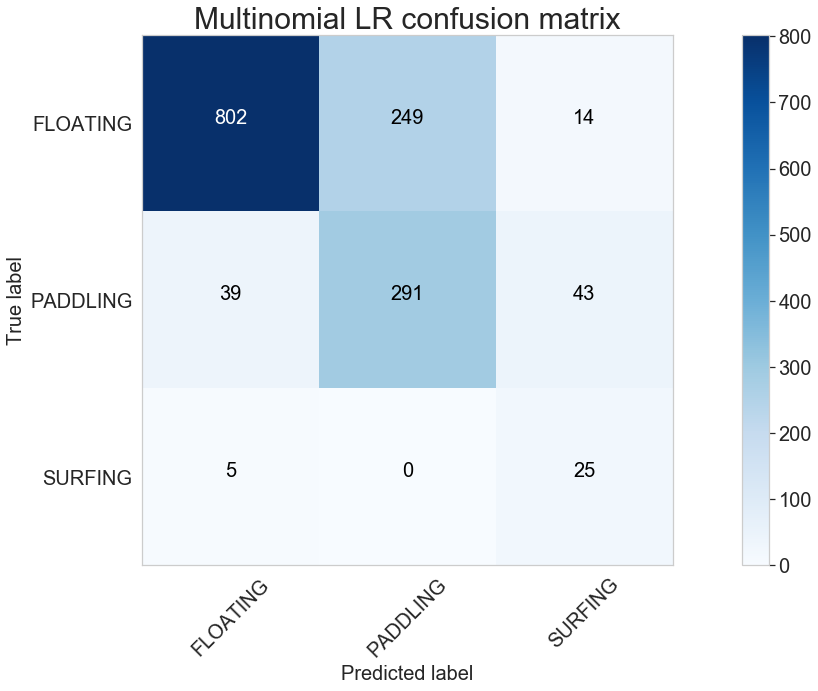

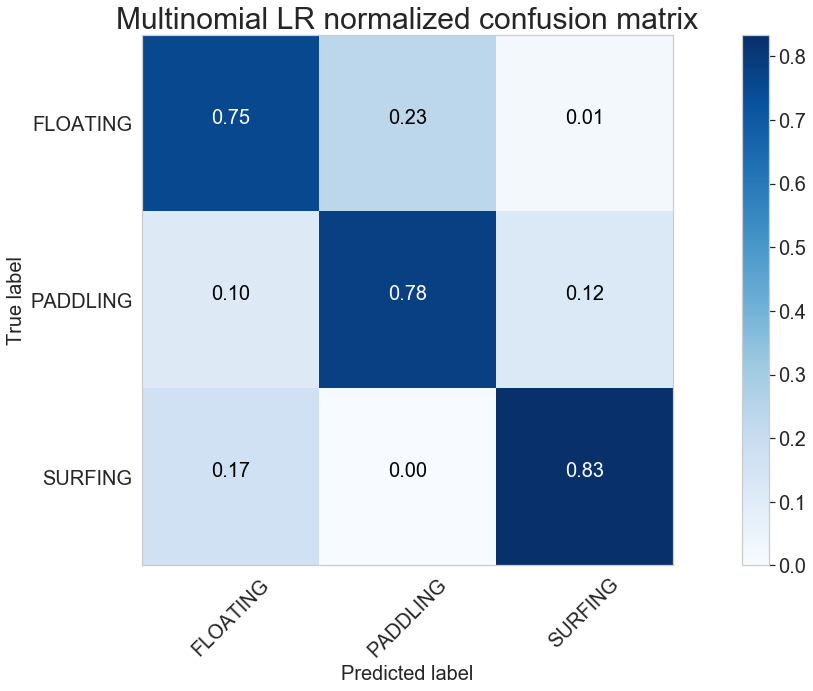

In [146]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()


In [52]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

print("Average score from confusion matrix:")
print(sum(score)/len(score))

TypeError: '<' not supported between instances of 'float' and 'str'

In [88]:
#Make sure all are type "float" in column: 
#complex_multiclass_df.loc[complex_multiclass_df.Complex_Label.apply(lambda x: isinstance(x, str))]


In [89]:
#Use SMOTE to balance out sets (but creates a LARGE dataset!)
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)

ValueError: Expected n_neighbors <= n_samples,  but n_samples = 4, n_neighbors = 6

In [ ]:
# Train multinomial logistic regression model using SMOTE
    
from sklearn import linear_model
from sklearn import metrics

mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
print(cm)        

In [ ]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()


In [ ]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

print("Average score from confusion matrix:")
print(sum(score)/len(score))

## Train on "simple" dataset too (to compare results to previous experiments):

In [ ]:
# Create "simple" dataset from "complex" dataset: 

print("Creating simple dataframe...")

#simple_multiclass_df = complex_multiclass_df.copy()
simple_multiclass_df = complex_multiclass_df

#print(complex_multiclass_df.head(10))
print("List:", list(complex_multiclass_df))

simple_labels = ["FLOATING", "PADDLING INTO WAVES", "PADDLING FOR A WAVE", "PADDLING FOR POSITION", "SURFING"]
simple_array = []


for name in complex_multiclass_df["Complex_Label"].values:
    #print(name)
    if name in simple_labels:
        if "PADDLING" in name: 
            name = "PADDLING"  
        simple_array.append(name)
    else:
        simple_array.append(0)
        
#print(simple_array)
    

simple_multiclass_df["Simple_Label"] = simple_array
simple_multiclass_df = simple_multiclass_df[simple_multiclass_df.Simple_Label != 0]

#simple_multiclass_df.loc[simple_multiclass_df['Complex_Label'].str.contains('PADDLING'), 'Complex_Label'] = 'PADDLING'
#simple_multiclass_df = simple_multiclass_df[simple_multiclass_df['Complex_Label'].str.match('FLOATING|PADDLING|SURFING')]

if "Complex_Label" in list(simple_multiclass_df):
    simple_multiclass_df = simple_multiclass_df.drop("Complex_Label", axis=1)



print("\n Done creating complex multiclass df.")

simple_multiclass_df.head(10)

In [ ]:
#Need to split into testing and training sets

X = simple_multiclass_df.iloc[:, :-1].values  #selects everything until the last column listed
y = simple_multiclass_df.iloc[:, -1].values   #selects the last column 


print("X.shape:", X.shape)
print("y.shape:", y.shape)


# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 0)

print("x_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("x_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

In [ ]:
#Use SMOTE to balance out sets (but creates a LARGE dataset!)
from imblearn.over_sampling import SMOTE, ADASYN

X_train_res, y_train_res = SMOTE().fit_resample(X_train, y_train)
print("X_resampled shape:", X_resampled.shape)
print("y_resampled shape:", y_resampled.shape)
    
# Train multinomial logistic regression model using SMOTE
    
from sklearn import linear_model
from sklearn import metrics

mul_lr = linear_model.LogisticRegression(multi_class='multinomial', solver='newton-cg').fit(X_train_res, y_train_res)
print("Multinomial Logistic regression Train Accuracy :: ", metrics.accuracy_score(y_train_res, mul_lr.predict(X_train_res)))
print("Multinomial Logistic regression Test Accuracy :: ", metrics.accuracy_score(y_test, mul_lr.predict(X_test)))
    
    
# Predicting the Test set results
y_pred = mul_lr.predict(X_test)

#Confusion matrix: C_ij is equal to the number of observations known to be in group i but predicted to be in group j.
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true=y_test, y_pred=y_pred, labels=labels)
print(cm)        

In [ ]:
%matplotlib inline

# import packages
import itertools
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# set up the figure size
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 30
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20


#axes.titlesize : 24
#axes.labelsize : 20
#lines.linewidth : 3
#lines.markersize : 10
#xtick.labelsize : 16
#ytick.labelsize : 16

class_names = ["FLOATING", "PADDLING", "SURFING"]

print("Plotting CM ...")

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Multinomial LR normalized confusion matrix")
    else:
        print('Multinomial LR confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
#cnf_matrix = confusion_matrix(y_test, y_pred)
#np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plt.grid('off')
plot_confusion_matrix(cm, classes=class_names,
                      title='Multinomial LR confusion matrix')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names, normalize=True,
                      title='Multinomial LR normalized confusion matrix')

plt.grid('off')

plt.show()


In [ ]:
# 10-cross Fold
from sklearn.model_selection import cross_val_score
score = cross_val_score(estimator = mul_lr, X = X_test, y = y_test, cv = 10)
print(score)

print("Average score from confusion matrix:")
print(sum(score)/len(score))